In [1]:
%matplotlib inline
datadir = './data/'

import urllib.request, os, gzip

def download_data(dataset_name, datadir):
    filename = 'reviews_%s_5.json' % dataset_name
    filepath = os.path.join(datadir, filename)
    if os.path.exists(filepath):
        print("Dataset %s has already been downloaded to %s" % (dataset_name, datadir))
    else:
        url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/%s.gz' % filename
        urllib.request.urlretrieve(url, filepath + ".gz")
        with gzip.open(filepath + ".gz", 'rb') as fin:
            with open(filepath, 'wb') as fout:
                fout.write(fin.read())
        print("Downloaded dataset %s and saved it to %s" % (dataset_name, datadir))

dataset = "Baby"
download_data(dataset, datadir)

Dataset Baby has already been downloaded to ./data/


In [2]:
import  json

def  load_data (dataset_name, datadir):
    filepath = os.path.join(datadir, 'reviews_%s_5.json' % dataset_name)
    if not os.path.exists(filepath):
        download_data(dataset_name, datadir)
    data = []
    with open(filepath, 'r') as f:
        for line in f:                            # read file line by line
            item_hash = hash(line)                # we will use this later for partitioning our data 
            item = json.loads(line)               # convert JSON string to Python dict
            item['hash'] = item_hash              # add hash for identification purposes
            data.append(item)
    print("Loaded %d data for dataset %s" % (len(data), dataset_name))
    return data

# load the data...
baby = load_data(dataset, datadir)


Loaded 160792 data for dataset Baby


In [3]:
def partition_train_validation_test(data):
    # 60% : modulus is 0, 1, 2, 3, 4, or 5
    data_train = [item for item in data if item['hash']%10<=5]  
    # 20% : modulus is 6 or 7
    data_valid = [item for item in data if item['hash']%10 in [6,7]] 
    # 20% : modulus is 8 or 9
    data_test  = [item for item in data if item['hash']%10 in [8,9]] 
    return data_train, data_valid, data_test
    
baby_train, baby_valid, baby_test = partition_train_validation_test(baby)


In [4]:
from  nltk.corpus  import opinion_lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

import random
random.seed(1234)
print("Some positive words:", ", ".join(random.sample(positive_words, 10)))
print("Some negative words:", ", ".join(random.sample(negative_words, 10)))


Some positive words: visionary, distinctive, ardent, compactly, stable, merciful, tremendously, dreamland, dead-cheap, fervid
Some negative words: contrariness, wasteful, unexpected, lost, afflict, ominous, gall, unsettling, misbehave, trample


In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
eng_stopwords = set(stopwords.words('english'))

def my_tokenize(text):
    # split text into lower-case tokens, removing all-punctuation tokens and stopwords
    tokens = []
    for sentence in sent_tokenize(text):
        tokens.extend(x for x in word_tokenize(sentence.lower()) 
                      if x not in eng_stopwords and any(i.isalpha() for i in x))
    return tokens

def pos_neg_fraction(text):
    tokens = my_tokenize(text)
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in positive_words:
            count_pos += 1
        if t in negative_words:
            count_neg += 1
    count_all = len(tokens)
    if count_all != 0:
        return count_pos/count_all, count_neg/count_all
    else:
        return 0., 0.
    
pos_example = 'This is a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example = 'This is a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction(pos_example))
print(pos_neg_fraction(neg_example))

(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)


In [6]:
import numpy

def dataset_to_matrix(data):
    return numpy.array([list(pos_neg_fraction(item['reviewText'])) for item in data])

X_train = dataset_to_matrix(baby_train) # We use only the train part
most_pos, most_neg = numpy.argmax(X_train, axis=0)
# print the example with the highest fraction of positive words:
print("We found a fraction of %f %% positive words for example %d" % 
      (100.*X_train[most_pos, 0], most_pos))
print(baby_train[most_pos])
print("We found a fraction of %f %% negative words for example %d" %
      (100.*X_train[most_neg, 1], most_neg))
print(baby_train[most_neg])

We found a fraction of 100.000000 % positive words for example 5872
{'reviewerID': 'AKU0ZZ3IEZW42', 'asin': 'B0001BUKA8', 'helpful': [0, 0], 'reviewText': 'useful peace', 'overall': 5.0, 'summary': 'Five Stars', 'unixReviewTime': 1405382400, 'reviewTime': '07 15, 2014', 'hash': -4229860844673062150}
We found a fraction of 100.000000 % negative words for example 15777
{'reviewerID': 'A2416HDN71TOGG', 'asin': 'B000HZEQSU', 'reviewerName': 'Elizabeth Evans', 'helpful': [0, 0], 'reviewText': 'uncomfortable', 'overall': 1.0, 'summary': 'One Star', 'unixReviewTime': 1404691200, 'reviewTime': '07 7, 2014', 'hash': -2402809534269020419}


In [7]:
def dataset_to_targets(data):
    return numpy.array([item['overall'] for item in data])

Y_train = dataset_to_targets(baby_train)
print("Our feature matrix is two-dimensional and has shape", X_train.shape)
print("Our target vector is one-dimensional and has shape", Y_train.shape)

Our feature matrix is two-dimensional and has shape (96696, 2)
Our target vector is one-dimensional and has shape (96696,)


 D_train that is true if the customer is **dissatisfied** (1, 2 or 3 stars), and false if the customer is satisfied (4 stars or better):

In [8]:
def discretize_targets(Y):
    return Y<=3.0

D_train = discretize_targets(Y_train)
print("The training data contains %f %% dissatisfied customers" % (100.*D_train.mean()))


The training data contains 21.282163 % dissatisfied customers


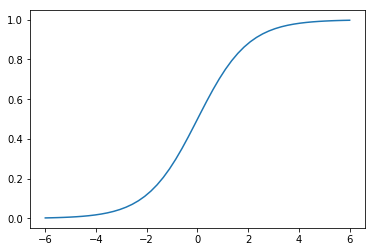

In [9]:
import pandas
points = numpy.linspace(-6.0, 6.0)
logistic_function = pandas.Series(1/(numpy.exp(-points)+1), index=points)
logistic_function.plot()

In [10]:
from sklearn.linear_model import LogisticRegression

logreg= LogisticRegression().fit(X_train,D_train)

#The predict_proba() method produces a matrix with two columns
#the first column contains the probaolity for the label being "fals""(satisfied costumer)
# the second column contains the probability for the label being "true" (dissatisfied customer)
# the sum of both columns is 1
#we select the second column with [:,1]
# [:,0] would select the first column
#[1,:] would select the second row

prob2_train = logreg.predict_proba(X_train)[:,1]
pred2_train = prob2_train > 0.5 # esto es un bool que da true o false
max_prob2 = numpy.argmax(prob2_train) # to test
min_prob2= numpy.argmin(prob2_train) # to test

def analyze_training_example_2(i):
    print("Training example number",i)
    print("True rating %f stars" %Y_train[i])
    print("Expected to be dissatisfied:", pred2_train[i])
    print("Expected probability of being dissatisfied : %f" % prob2_train[i])
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % baby_train[i]['reviewText'])
    
analyze_training_example_2(max_prob2)

Training example number 15777
True rating 1.000000 stars
Expected to be dissatisfied: True
Expected probability of being dissatisfied : 0.999865
Features = 0.000000 / 1.000000
Review text = uncomfortable


In [11]:
analyze_training_example_2(min_prob2)

Training example number 5872
True rating 5.000000 stars
Expected to be dissatisfied: False
Expected probability of being dissatisfied : 0.000041
Features = 1.000000 / 0.000000
Review text = useful peace


In [12]:
# Recall.. how many (%) dissatisfied custumers did we identified as dissatisfed
#Precision... of all the identified as "dissatisfied", which porcetage was actually dissatisfied
from sklearn.metrics import precision_score, recall_score
precision2 = precision_score(D_train,pred2_train)
recall2 = recall_score(D_train,pred2_train)
print("For the default threshold (0.5) we get precision = %f "
      "and recall = %f" % (precision2, recall2))

For the default threshold (0.5) we get precision = 0.606013 and recall = 0.094028


60% of the ones we said were not satisfied were dissatisfied ( so actually around 40% were sattisfied)
10%  of the dissatisfied costumers were correctly labled by our algorithm (we left almost 90% out)

Precision as function of threshold: 


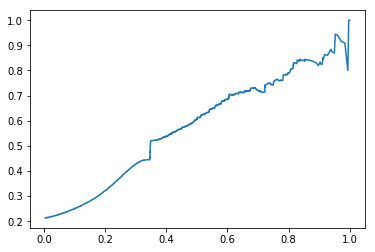

In [13]:
from sklearn.metrics import precision_recall_curve
all_precision2, all_recall2, all_thresh2 = precision_recall_curve(
    D_train, prob2_train)
print("Precision as function of threshold: ")
pandas.Series(all_precision2[:-1], index = all_thresh2).plot()

Recall as function of threshold:


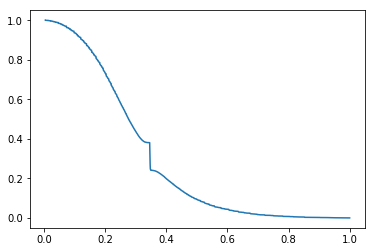

In [14]:
print("Recall as function of threshold:")
pandas.Series(all_recall2[:-1], index=all_thresh2).plot()

Recall as function of precision:


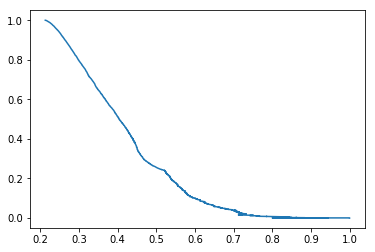

In [15]:
print("Recall as function of precision:")
pandas.Series(all_recall2[:-1], index=all_precision2[:-1]).plot()

Now the precision is 0.479406 and the recall is 0.153846


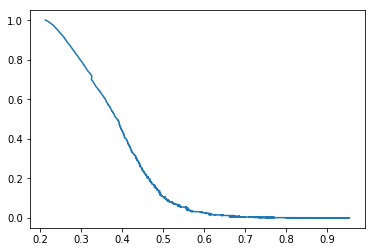

In [16]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
nb = GaussianNB().fit(X_train, D_train)
prob3_train = nb.predict_proba(X_train)[:,1]
pred3_train = prob3_train >0.5
precision3 = precision_score(D_train, pred3_train)
recall3 = recall_score(D_train,pred3_train)
print("Now the precision is %f and the recall is %f" % (precision3, recall3))
all_precision3, all_recall3, all_thresh3 = precision_recall_curve(
    D_train, prob3_train)
pandas.Series(all_recall3[:-1], index=all_precision3[:-1]).plot()

In [17]:
import tensorflow as tf
feat_cols = [tf.feature_column.numeric_column(key="fpos"),
            tf.feature_column.numeric_column(key="fneg")]
model = tf.estimator.LinearRegressor(feature_columns =feat_cols)

get_training_data = tf.estimator.inputs.numpy_input_fn(
                        x={"fpos" : X_train[:,0], "fneg" : X_train[:,1]},
                        y = Y_train, num_epochs = None, shuffle = True 
                        )

model.train(input_fn = get_training_data, steps = 5000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\MAGUIL~1\\AppData\\Local\\Temp\\tmpm2cy4tkk', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001CE5354A2E8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 

In [18]:
from sklearn.metrics import mean_absolute_error
eval_training_data = tf.estimator.inputs.numpy_input_fn(
                     x={"fpos":X_train[:,0], "fneg": X_train[:,1]},
                     num_epochs=1, shuffle=False)
pred_train_tf = numpy.array([item['predictions'][0] for item in 
                         model.predict(input_fn=eval_training_data)])
mae_train_tf = mean_absolute_error(pred_train_tf, Y_train)
print("The mean absolute error on the training data is %f stars" 
      % mae_train_tf)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MAGUIL~1\AppData\Local\Temp\tmpm2cy4tkk\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The mean absolute error on the training data is 0.841767 stars


# NLTK Built In Sentiment Analyzer

In [21]:

from  nltk.sentiment  import SentimentAnalyzer
from nltk.sentiment.util import mark_negation
examples_negation = ["This product wasn't bad.",
                     "This is not a bad product.",
                     "This product was bad.",
                     "This is a bad product."]

for sentence in examples_negation:
    tokens_with_negation = mark_negation(word_tokenize(sentence.lower()))
    print("Sentence =", sentence)
    print(tokens_with_negation)

negated_stopwords = set(x+"_NEG" for x in eng_stopwords)
all_stopwords = eng_stopwords.union(negated_stopwords)        # set union
    
def tokenize_with_negation(text):
    # split text into lower-case tokens, removing all-punctuation tokens and stopwords
    tokens = []
    for sentence in sent_tokenize(text):
        pretokens = word_tokenize(sentence.lower())
        pretokens = [x for x in pretokens if any(i.isalpha() for i in x)]
        pretokens = mark_negation(pretokens)
        tokens.extend(x for x in pretokens if x not in all_stopwords)
    return tokens

print(baby_train[31]['reviewText'])
print(tokenize_with_negation(baby_train[31]['reviewText']))

Sentence = This product wasn't bad.
['this', 'product', 'was', "n't", 'bad_NEG', '.']
Sentence = This is not a bad product.
['this', 'is', 'not', 'a_NEG', 'bad_NEG', 'product_NEG', '.']
Sentence = This product was bad.
['this', 'product', 'was', 'bad', '.']
Sentence = This is a bad product.
['this', 'is', 'a', 'bad', 'product', '.']
This is a wonderful toy that is fun, educational, and affordable! The cars are different colors, and each has a different number, 1 - 4, to help a child learn counting and colors. They also stack on top of each other and nest inside of each other.(The nesting feature is great for storage too). Each car has a neat fun feature for little ones to explore (e.g., the small car is also a rattle, the large fire truck's ladder moves, etc.) The cars are also very sturdy (as has been proven by my son repeatedly banging them together,) and they are easy for little hands to grab onto. At 6 months of age, my son really enjoys looking at the toys, passing them from one h

c:\users\maguileracanon\appdata\local\programs\python\python36\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [23]:

all_positive_words  = positive_words.union({x+"_NEG" for x in negative_words})
all_negative_words = negative_words.union({x+"_NEG" for x in positive_words})

def pos_neg_fraction_with_negation(text):
    tokens = tokenize_with_negation(text)
    # count how many positive and negative words occur in the text
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in all_positive_words:
            count_pos += 1
        if t in all_negative_words:
            count_neg += 1
    count_all = len(tokens)
    if count_all != 0:
        return count_pos/count_all, count_neg/count_all
    else:  # avoid division by zero
        return 0., 0.
    
pos_example = 'This is a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example = 'This is a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction_with_negation(pos_example))
print(pos_neg_fraction_with_negation(neg_example))

(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)


In [24]:
pos_example_neg = 'This is not a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example_neg = 'This is not a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction_with_negation(pos_example_neg))
print(pos_neg_fraction_with_negation(neg_example_neg))

(0.0, 0.8571428571428571)
(0.8571428571428571, 0.0)


In [25]:
def dataset_to_matrix_with_neg(data):
    return numpy.array([list(pos_neg_fraction_with_negation(item['reviewText'])) for item in data])

X_train_neg = dataset_to_matrix_with_neg(baby_train)

In [27]:
from sklearn.linear_model import LinearRegression
lreg_neg = LinearRegression().fit(X_train_neg, Y_train)
pred_train_neg = lreg_neg.predict(X_train_neg)
mae_train_with_neg = mean_absolute_error(pred_train_neg, Y_train)
print("Now the mean absolute error on the training data is %f stars" % mae_train_with_neg)

Now the mean absolute error on the training data is 0.813047 stars


# Random Forest

In [29]:
from sklearn.ensemble import RandomForestRegressor
rf_neg = RandomForestRegressor().fit(X_train_neg,Y_train)
pred_train_rf_neg = rf_neg.predict(X_train_neg)
mae_train_rf_neg = mean_absolute_error(pred_train_rf_neg, Y_train)
print("A nonlinear regressor achieves a MAE of %f stars" % mae_train_rf_neg)

A nonlinear regressor achieves a MAE of 0.713325 stars


In [30]:
baby_train[50000]['reviewText']

"I really like this stroller. It's smooth and so light. We were still using our travel system stroller. My son loves going for walks in this one.Pros:Easy to steerComfy for childGreat cup holder/zipper pouchHas a basketHigher handles5 point harnessThe straps are easy to adjustCons:The recline is kind of cheap and odd to use. It's a set of small ropes that you slide a plastic thing on to adjust.. You only have sitting up and a very slight recline.The basket is not easily accessible. The opening is narrow because of the bars.The crotch strap is way too close to the back of the seat rather than the front. I had to make it as loose as it can go, but it's still underneath my son. I don't like that at all, and it seems as he gets bigger it will be even more uncomfortable for him."

In [36]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia= SentimentIntensityAnalyzer()
text = baby_train[50000]['reviewText']
for s in sent_tokenize(text):
    print(s)
    print(sia.polarity_scores(s))
    

I really like this stroller.
{'neg': 0.0, 'neu': 0.518, 'pos': 0.482, 'compound': 0.4201}
It's smooth and so light.
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
We were still using our travel system stroller.
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
My son loves going for walks in this one.Pros:Easy to steerComfy for childGreat cup holder/zipper pouchHas a basketHigher handles5 point harnessThe straps are easy to adjustCons:The recline is kind of cheap and odd to use.
{'neg': 0.058, 'neu': 0.777, 'pos': 0.165, 'compound': 0.6486}
It's a set of small ropes that you slide a plastic thing on to adjust.. You only have sitting up and a very slight recline.The basket is not easily accessible.
{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'compound': -0.2584}
The opening is narrow because of the bars.The crotch strap is way too close to the back of the seat rather than the front.
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
I had to make it as loose as it can go, but

what is compound?

In [41]:
def sia_features(dataset):
    '''
    For each review text in the dataset, extract: 
    (1) mean positive sentiment over all sentences
    (2) mean neutral sentiment over all sentences
    (3) mean negative sentiment over all  sentences
    (4) maximum postive sentiment over all sentences
    (5) maximum neutral sentiment over all sentences
    (6) maximum negative sentiment over al sentences 
'''
    feat_matrix = numpy.empty((len(dataset),6))
    for i in range(len(dataset)):
        sentences = sent_tokenize(dataset[i]['reviewText'])
        nsent = len(sentences)
        if nsent:
            sentences_polarities = numpy.empty((nsent,3))
            for j in range(nsent):
                polarity = sia.polarity_scores(sentences[j])
                sentences_polarities[j,0] = polarity['pos']
                sentences_polarities[j,1] = polarity['neu']
                sentences_polarities[j,2] = polarity['neg']
            feat_matrix[i, 0:3] = numpy.mean(sentences_polarities, axis = 0) #axis 0 is row, axis 1 is columns
            feat_matrix[i,3:6] = numpy.max(sentences_polarities, axis = 0)
        else:
            feat_matrix[i, 0:6] = 0.0
            
    return feat_matrix
            
sia_tr = sia_features(baby_train)


In [42]:
print(sia_tr)

[[0.23533333 0.76466667 0.         0.552      1.         0.        ]
 [0.03833333 0.84266667 0.119      0.115      1.         0.357     ]
 [0.172      0.8174     0.0106     0.398      1.         0.053     ]
 ...
 [0.309      0.691      0.         0.309      0.691      0.        ]
 [0.2732     0.7268     0.         0.497      1.         0.        ]
 [0.22825    0.7155     0.05625    0.672      1.         0.225     ]]


In [ ]:
def len_features(dataset):
    '''
    Add two features:
    (1) lenght of review (in thousands of characters) - truncate at 2500
    (2) percengate of exclamation marks (in 5)    
    '''
len_tr = len_features(baby_train)

In [45]:
print(X_train_neg.shape, sia_tr.shape)

(96696, 2) (96696, 6)


In [48]:
# stack horizontally 
X_train_augmented = numpy.concatenate(( X_train_neg, sia_tr) ,axis = 1)
lreg_augmented = LinearRegression().fit(X_train_augmented,Y_train)
pred_train_augmented = lreg_augmented.predict(X_train_augmented)
mean_train_augmented = mean_absolute_error(pred_train_augmented, Y_train)
print("Now the mean absolute error on the training data is %f starts" % mean_train_augmented)

Now the mean absolute error on the training data is 0.756362 starts


In [49]:
# random forest
rf_augmented = RandomForestRegressor().fit(X_train_augmented, Y_train)
rfpred_train_augmented = rf_augmented.predict(X_train_augmented)
mae_train_rf_augmented = mean_absolute_error(rfpred_train_augmented, Y_train)
print("For the RF, MAE is %f stars" % mae_train_rf_augmented)

For the RF, MAE is 0.292731 stars


Now we vlaidation data

In [ ]:
X_valid_neg = dataset_to_matrix(baby_valid)
sia_valid = sia_features(baby_valid)
#leng_valid
X_valid_augmented = numpy.concatenate((X_valid_neg,sia_valid), axis = 1)
pred_valid_augmented = lreg_augmented.predict(X_valid_augmented)
pred_valid_rf_augmented = rf
mae_valid_augmented = 
mae_valid_rfaugemented = 